In [ ]:
# import kagglehub
# import os
# # os.mkdir('Data')
# # Download latest version
# # path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")
# # print("Path to dataset files:", path)

100%|██████████| 204M/204M [00:20<00:00, 10.5MB/s] 

Extracting files...


Path to dataset files: C:\Users\uikra\.cache\kagglehub\datasets\shashwatwork\knee-osteoarthritis-dataset-with-severity\versions\1


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

In [50]:
# # import os
# # import pandas as pd

# # def load_dataset_as_dataframe(subdir):
# #     # Define the path to the dataset
# #     data_dir = f'e:\\Bahria University\\Open-CV lab\\Project\\{subdir}'
# #     print(f'Load dataset from `{subdir}` subdirectory')

# #     # Create lists to store image paths and labels
# #     image_paths = []
# #     labels = []

# #     # Get the list of class directories
# #     classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
# #     classes.sort()
# #     print('Classes:', classes)

# #     # Map class names to labels
# #     class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

# #     # Loop over each class directory
# #     for class_name in classes:
# #         class_dir = os.path.join(data_dir, class_name)
# #         label = class_to_idx[class_name]
# #         # Get all image files in the class directory
# #         for img_name in os.listdir(class_dir):
# #             img_path = os.path.join(class_dir, img_name)
# #             if os.path.isfile(img_path):
# #                 image_paths.append(img_path)
# #                 labels.append(label)

# #     # Create a DataFrame
# #     data = pd.DataFrame({
# #         'image_path': image_paths,
# #         'label': labels
# #     })

# #     # Show the distribution of labels in the dataset
# #     dataset_distribution_dict = {i: len(data[data['label'] == i]) for i in range(len(classes))}
# #     print(dataset_distribution_dict)
# #     print()

# #     return data

# import os
# import pandas as pd

# def load_dataset_as_dataframe(subdir, max_images=100):
#     # Define the path to the dataset
#     data_dir = f'e:\\Bahria University\\Open-CV lab\\Project\\{subdir}'
#     print(f'Load dataset from `{subdir}` subdirectory')

#     # Create lists to store image paths and labels
#     image_paths = []
#     labels = []

#     # Get the list of class directories
#     classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
#     classes.sort()
#     print('Classes:', classes)

#     # Map class names to labels
#     class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

#     # Counter to track the number of images processed
#     count = 0

#     # Loop over each class directory
#     for class_name in classes:
#         class_dir = os.path.join(data_dir, class_name)
#         label = class_to_idx[class_name]
#         # Get all image files in the class directory
#         for img_name in os.listdir(class_dir):
#             if count >= max_images:
#                 break  # Stop if the maximum number of images is reached
#             img_path = os.path.join(class_dir, img_name)
#             if os.path.isfile(img_path):
#                 image_paths.append(img_path)
#                 labels.append(label)
#                 count += 1
#         if count >= max_images:
#             break  # Stop processing if the maximum number of images is reached

#     # Create a DataFrame
#     data = pd.DataFrame({
#         'image_path': image_paths,
#         'label': labels
#     })

#     # Show the distribution of labels in the dataset
#     dataset_distribution_dict = {i: len(data[data['label'] == i]) for i in range(len(classes))}
#     print(dataset_distribution_dict)
#     print()

#     return data



In [17]:
def load_dataset_as_dataframe(subdir, max_images=1500):
    data_dir = f'Data\\{subdir}'
    print(f'Loading dataset from `{subdir}` subdirectory')

    image_paths = []
    labels = []

    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        count = 0  # Reset count for each class
        for img_name in os.listdir(class_dir):
            if count >= max_images:
                break
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)
                count += 1

    data = pd.DataFrame({'image_path': image_paths, 'label': labels})
    dataset_distribution_dict = {i: len(data[data['label'] == i]) for i in range(len(classes))}
    print(dataset_distribution_dict)
    print()

    return data


In [18]:
# Define classes
classes = ['0', '1', '2', '3', '4']

# Load training and testing datasets
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')

Loading dataset from `train` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 1500, 1: 1046, 2: 1500, 3: 757, 4: 173}

Loading dataset from `test` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 639, 1: 296, 2: 447, 3: 223, 4: 51}



In [20]:
# Define image transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [21]:
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)  # Reset the index for consistency
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        if self.transform:
            image = self.transform(image)  # Apply transformations
        return image, label


In [22]:
# Create dataset instances
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [23]:
# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1
    plt.imshow(img)
    plt.axis('off')

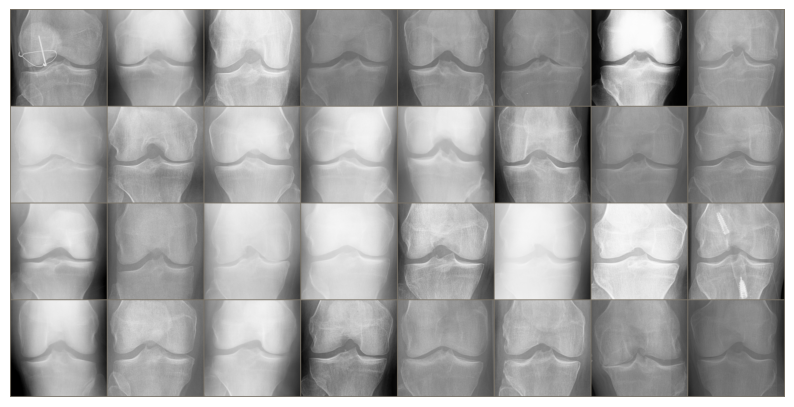

In [24]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from the batch of images
out = utils.make_grid(images)

# Display images in a grid
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()

In [25]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [26]:
# Get the size of the dataset
print(f"Size of the training dataset: {len(train_dataset)}")
print(f"Size of the test dataset: {len(test_dataset)}")

Size of the training dataset: 4976
Size of the test dataset: 1656


In [27]:
model = models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)

c:\DeepChainSols\CV semester project\myvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\DeepChainSols\CV semester project\myvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\uikra/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.81MB/s]


In [28]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Number of epochs to run
num_epochs = 50

# Initialize lists to store metrics
train_losses = []
train_accuracies = []

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * images.size(0)
        
        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    
    # Store metrics for plotting later
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# Save the model's state_dict after training
# torch.save(model.state_dict(), '/content/drive/MyDrive/CV Project/resnet.pth')

Epoch [1/50]: 100%|██████████| 156/156 [14:32<00:00,  5.59s/it, loss=1.2186, acc=44.29%]


Epoch [1/50], Loss: 1.2492, Accuracy: 0.4429


Epoch [2/50]: 100%|██████████| 156/156 [09:13<00:00,  3.55s/it, loss=0.8393, acc=54.06%]


Epoch [2/50], Loss: 1.0343, Accuracy: 0.5406


Epoch [3/50]: 100%|██████████| 156/156 [10:31<00:00,  4.05s/it, loss=0.9582, acc=58.90%]


Epoch [3/50], Loss: 0.9469, Accuracy: 0.5890


Epoch [4/50]: 100%|██████████| 156/156 [11:01<00:00,  4.24s/it, loss=0.4925, acc=61.17%]


Epoch [4/50], Loss: 0.8956, Accuracy: 0.6117


Epoch [5/50]: 100%|██████████| 156/156 [12:54<00:00,  4.97s/it, loss=1.1705, acc=63.24%]


Epoch [5/50], Loss: 0.8479, Accuracy: 0.6324


Epoch [6/50]: 100%|██████████| 156/156 [10:34<00:00,  4.06s/it, loss=0.7548, acc=65.39%]


Epoch [6/50], Loss: 0.8008, Accuracy: 0.6539


Epoch [7/50]: 100%|██████████| 156/156 [14:32<00:00,  5.59s/it, loss=0.8061, acc=65.27%]


Epoch [7/50], Loss: 0.7906, Accuracy: 0.6527


Epoch [8/50]: 100%|██████████| 156/156 [14:22<00:00,  5.53s/it, loss=0.5314, acc=67.48%]


Epoch [8/50], Loss: 0.7524, Accuracy: 0.6748


Epoch [9/50]: 100%|██████████| 156/156 [13:36<00:00,  5.23s/it, loss=0.8613, acc=70.74%]


Epoch [9/50], Loss: 0.6936, Accuracy: 0.7074


Epoch [10/50]: 100%|██████████| 156/156 [07:48<00:00,  3.00s/it, loss=0.9292, acc=71.50%]


Epoch [10/50], Loss: 0.6665, Accuracy: 0.7150


Epoch [11/50]: 100%|██████████| 156/156 [4:55:09<00:00, 113.52s/it, loss=1.0457, acc=74.08%]   


Epoch [11/50], Loss: 0.6223, Accuracy: 0.7408


Epoch [12/50]: 100%|██████████| 156/156 [08:29<00:00,  3.27s/it, loss=1.0289, acc=75.60%]


Epoch [12/50], Loss: 0.5862, Accuracy: 0.7560


Epoch [13/50]: 100%|██████████| 156/156 [08:35<00:00,  3.30s/it, loss=0.4365, acc=77.91%]


Epoch [13/50], Loss: 0.5316, Accuracy: 0.7791


Epoch [14/50]: 100%|██████████| 156/156 [09:03<00:00,  3.48s/it, loss=0.5261, acc=80.00%]


Epoch [14/50], Loss: 0.4883, Accuracy: 0.8000


Epoch [15/50]: 100%|██████████| 156/156 [09:13<00:00,  3.55s/it, loss=0.3527, acc=83.12%]


Epoch [15/50], Loss: 0.4429, Accuracy: 0.8312


Epoch [16/50]: 100%|██████████| 156/156 [08:58<00:00,  3.45s/it, loss=0.4203, acc=85.29%]


Epoch [16/50], Loss: 0.3775, Accuracy: 0.8529


Epoch [17/50]: 100%|██████████| 156/156 [09:12<00:00,  3.54s/it, loss=0.4634, acc=86.82%]


Epoch [17/50], Loss: 0.3493, Accuracy: 0.8682


Epoch [18/50]: 100%|██████████| 156/156 [08:35<00:00,  3.30s/it, loss=0.3691, acc=88.18%]


Epoch [18/50], Loss: 0.3142, Accuracy: 0.8818


Epoch [19/50]: 100%|██████████| 156/156 [08:36<00:00,  3.31s/it, loss=0.2995, acc=90.57%]


Epoch [19/50], Loss: 0.2549, Accuracy: 0.9057


Epoch [20/50]: 100%|██████████| 156/156 [08:43<00:00,  3.36s/it, loss=0.6223, acc=91.64%]


Epoch [20/50], Loss: 0.2385, Accuracy: 0.9164


Epoch [21/50]: 100%|██████████| 156/156 [09:19<00:00,  3.59s/it, loss=0.1433, acc=92.38%]


Epoch [21/50], Loss: 0.2068, Accuracy: 0.9238


Epoch [22/50]: 100%|██████████| 156/156 [09:00<00:00,  3.47s/it, loss=0.5085, acc=92.50%]


Epoch [22/50], Loss: 0.2037, Accuracy: 0.9250


Epoch [23/50]: 100%|██████████| 156/156 [09:28<00:00,  3.65s/it, loss=0.0819, acc=94.51%]


Epoch [23/50], Loss: 0.1461, Accuracy: 0.9451


Epoch [24/50]: 100%|██████████| 156/156 [09:14<00:00,  3.56s/it, loss=0.0961, acc=95.64%]


Epoch [24/50], Loss: 0.1267, Accuracy: 0.9564


Epoch [25/50]: 100%|██████████| 156/156 [09:20<00:00,  3.59s/it, loss=0.1533, acc=94.77%]


Epoch [25/50], Loss: 0.1361, Accuracy: 0.9477


Epoch [26/50]: 100%|██████████| 156/156 [07:50<00:00,  3.02s/it, loss=0.0170, acc=95.32%]


Epoch [26/50], Loss: 0.1385, Accuracy: 0.9532


Epoch [27/50]: 100%|██████████| 156/156 [08:31<00:00,  3.28s/it, loss=0.2353, acc=96.18%]


Epoch [27/50], Loss: 0.1050, Accuracy: 0.9618


Epoch [28/50]: 100%|██████████| 156/156 [08:26<00:00,  3.24s/it, loss=0.2660, acc=95.60%]


Epoch [28/50], Loss: 0.1238, Accuracy: 0.9560


Epoch [29/50]: 100%|██████████| 156/156 [08:35<00:00,  3.30s/it, loss=0.0815, acc=96.64%]


Epoch [29/50], Loss: 0.0910, Accuracy: 0.9664


Epoch [30/50]: 100%|██████████| 156/156 [08:26<00:00,  3.25s/it, loss=0.0046, acc=96.99%]


Epoch [30/50], Loss: 0.0882, Accuracy: 0.9699


Epoch [31/50]: 100%|██████████| 156/156 [08:30<00:00,  3.27s/it, loss=0.0466, acc=97.19%]


Epoch [31/50], Loss: 0.0804, Accuracy: 0.9719


Epoch [32/50]: 100%|██████████| 156/156 [08:32<00:00,  3.29s/it, loss=0.1195, acc=96.91%]


Epoch [32/50], Loss: 0.0889, Accuracy: 0.9691


Epoch [33/50]: 100%|██████████| 156/156 [08:34<00:00,  3.30s/it, loss=0.0110, acc=97.25%]


Epoch [33/50], Loss: 0.0803, Accuracy: 0.9725


Epoch [34/50]: 100%|██████████| 156/156 [08:16<00:00,  3.19s/it, loss=0.1627, acc=96.50%]


Epoch [34/50], Loss: 0.0934, Accuracy: 0.9650


Epoch [35/50]: 100%|██████████| 156/156 [08:30<00:00,  3.27s/it, loss=0.1085, acc=96.86%]


Epoch [35/50], Loss: 0.0901, Accuracy: 0.9686


Epoch [36/50]: 100%|██████████| 156/156 [08:32<00:00,  3.29s/it, loss=0.0515, acc=97.41%]


Epoch [36/50], Loss: 0.0814, Accuracy: 0.9741


Epoch [37/50]: 100%|██████████| 156/156 [08:30<00:00,  3.27s/it, loss=0.2596, acc=97.23%]


Epoch [37/50], Loss: 0.0730, Accuracy: 0.9723


Epoch [38/50]: 100%|██████████| 156/156 [08:35<00:00,  3.30s/it, loss=0.2322, acc=97.59%]


Epoch [38/50], Loss: 0.0738, Accuracy: 0.9759


Epoch [39/50]: 100%|██████████| 156/156 [08:30<00:00,  3.27s/it, loss=0.0037, acc=97.33%]


Epoch [39/50], Loss: 0.0748, Accuracy: 0.9733


Epoch [40/50]: 100%|██████████| 156/156 [08:27<00:00,  3.25s/it, loss=0.1688, acc=98.31%]


Epoch [40/50], Loss: 0.0470, Accuracy: 0.9831


Epoch [41/50]: 100%|██████████| 156/156 [08:26<00:00,  3.25s/it, loss=0.3440, acc=98.17%]


Epoch [41/50], Loss: 0.0578, Accuracy: 0.9817


Epoch [42/50]: 100%|██████████| 156/156 [08:19<00:00,  3.20s/it, loss=0.3440, acc=98.05%]


Epoch [42/50], Loss: 0.0576, Accuracy: 0.9805


Epoch [43/50]: 100%|██████████| 156/156 [08:33<00:00,  3.29s/it, loss=0.1517, acc=97.89%]


Epoch [43/50], Loss: 0.0585, Accuracy: 0.9789


Epoch [44/50]: 100%|██████████| 156/156 [08:14<00:00,  3.17s/it, loss=0.0552, acc=97.87%]


Epoch [44/50], Loss: 0.0653, Accuracy: 0.9787


Epoch [45/50]: 100%|██████████| 156/156 [08:02<00:00,  3.10s/it, loss=0.0275, acc=98.03%]


Epoch [45/50], Loss: 0.0548, Accuracy: 0.9803


Epoch [46/50]: 100%|██████████| 156/156 [07:56<00:00,  3.06s/it, loss=0.0528, acc=97.73%]


Epoch [46/50], Loss: 0.0614, Accuracy: 0.9773


Epoch [47/50]: 100%|██████████| 156/156 [08:01<00:00,  3.09s/it, loss=0.0030, acc=98.01%]


Epoch [47/50], Loss: 0.0530, Accuracy: 0.9801


Epoch [48/50]: 100%|██████████| 156/156 [07:55<00:00,  3.05s/it, loss=0.0306, acc=97.51%]


Epoch [48/50], Loss: 0.0698, Accuracy: 0.9751


Epoch [49/50]: 100%|██████████| 156/156 [08:02<00:00,  3.09s/it, loss=0.0500, acc=98.07%]


Epoch [49/50], Loss: 0.0546, Accuracy: 0.9807


Epoch [50/50]: 100%|██████████| 156/156 [08:11<00:00,  3.15s/it, loss=0.1945, acc=98.63%]

Epoch [50/50], Loss: 0.0383, Accuracy: 0.9863


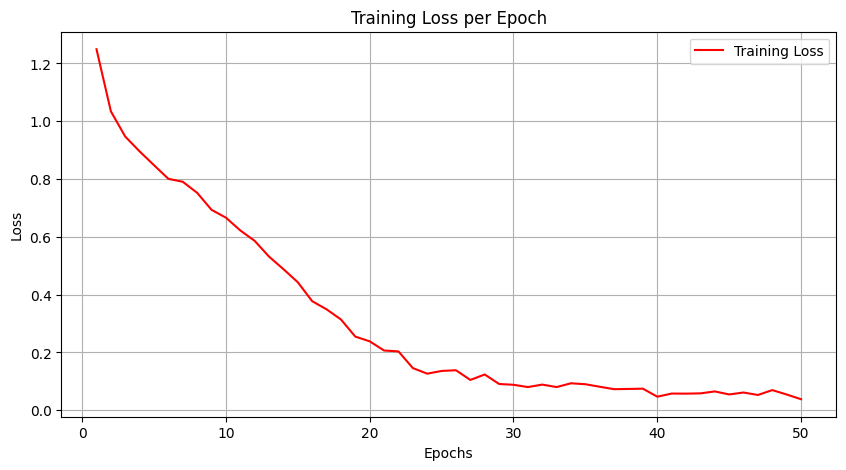

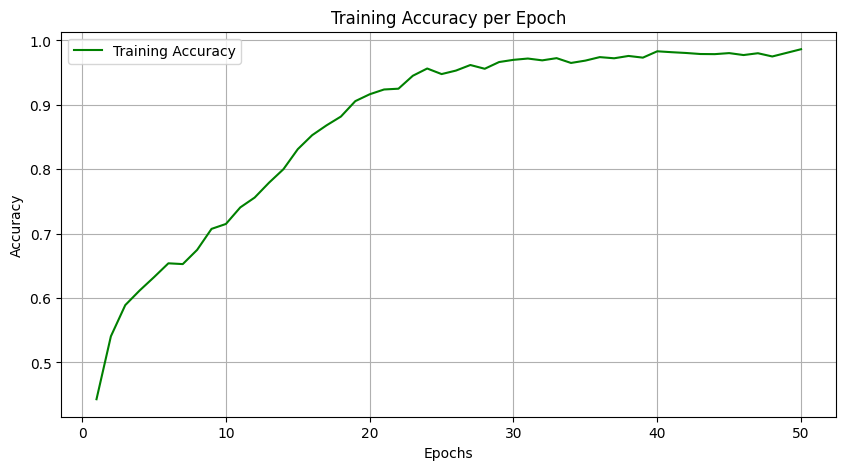

In [30]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import torch
from sklearn.metrics import accuracy_score

def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get class predictions

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return accuracy


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
torch.save(model, 'Classifier.pth')

In [ ]:
test_accuracy = test_model(model, test_loader, device)  

Test Accuracy: 59.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7589979].


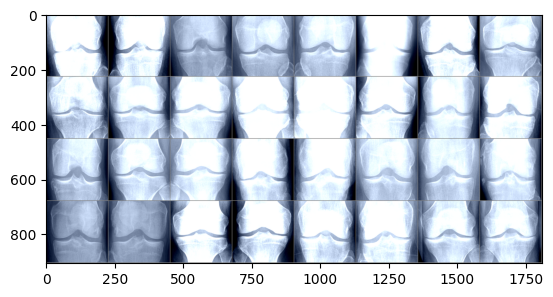

Predicted labels: [0 1 0 0 0 0 0 0 0 0 0 0 1 0 2 1 2 0 0 0 0 0 0 2 0 0 0 0 0 0 1 1]
True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [34]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Visualize
imshow(torchvision.utils.make_grid(images.cpu()))
print("Predicted labels:", preds.cpu().numpy())
print("True labels:", labels.numpy())


In [35]:
class_names = ["Grade 0: Healthy", "Grade 1: Doubtful", "Grade 2: Minimal", "Grade 3: Moderate", "Grade 4: Severe"]

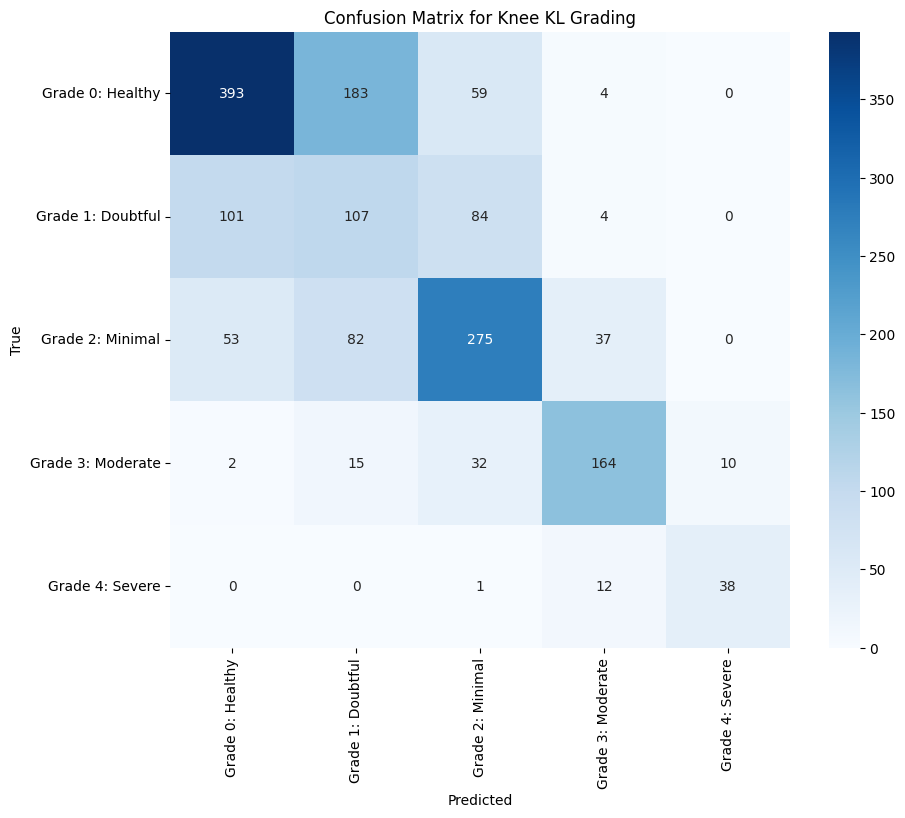

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_knee_confusion_matrix(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Class Labels
    class_names = ["Grade 0: Healthy", "Grade 1: Doubtful", "Grade 2: Minimal", "Grade 3: Moderate", "Grade 4: Severe"]

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Knee KL Grading')
    plt.show()

# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
plot_knee_confusion_matrix(model, test_loader, device)


In [37]:
from sklearn.metrics import classification_report


true_labels = []
predicted_labels = []

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        # Move data to the appropriate device (e.g., GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Make predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Collect true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Generate the classification report
classes = ['Grade 0: Healthy', 'Grade 1: Doubtful', 'Grade 2: Minimal', 'Grade 3: Moderate', 'Grade 4: Severe']
print(classification_report(true_labels, predicted_labels, target_names=classes))


                   precision    recall  f1-score   support

 Grade 0: Healthy       0.72      0.62      0.66       639
Grade 1: Doubtful       0.28      0.36      0.31       296
 Grade 2: Minimal       0.61      0.62      0.61       447
Grade 3: Moderate       0.74      0.74      0.74       223
  Grade 4: Severe       0.79      0.75      0.77        51

         accuracy                           0.59      1656
        macro avg       0.63      0.61      0.62      1656
     weighted avg       0.61      0.59      0.60      1656



c:\DeepChainSols\CV semester project\myvenv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


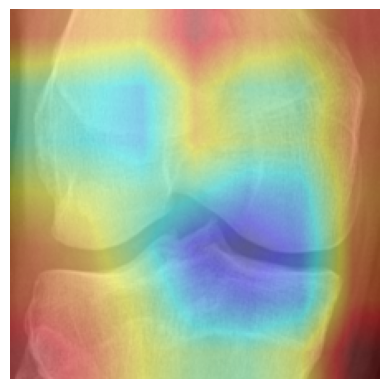

In [46]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models

# Assuming you have a pre-trained ResNet model
model = models.resnet18(pretrained=True)  # Use ResNet50 or your custom ResNet model
model.eval()  # Set model to evaluation mode

# Define Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None

        # Hook for saving the gradient and activation
        self.hook_layers()

    def hook_layers(self):
        # Hook for activation
        def save_activation(module, input, output):
            self.activation = output.detach()

        # Hook for gradients
        def save_gradient(module, input, output):
            self.gradient = output[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_backward_hook(save_gradient)

    def generate_cam(self, input_image, class_idx=None):
        # Forward pass
        output = self.model(input_image)
        
        # If no class_idx is provided, use the predicted class
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero gradients for all variables
        self.model.zero_grad()

        # Backward pass to get gradients
        output[:, class_idx].backward(retain_graph=True)

        # Get the gradient and activation
        gradients = self.gradient
        activation = self.activation

        # Pool the gradients across the channels
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)

        # Create the CAM by performing a weighted sum of activations
        cam = torch.sum(weights * activation, dim=1)

        # Apply ReLU (we only care about positive contributions)
        cam = F.relu(cam)

        # Normalize the CAM to [0, 1]
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().cpu().numpy()

# Load an image and preprocess it
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # Convert to PyTorch tensor and normalize
    image = image / 255.0
    image = torch.tensor(image).permute(2, 0, 1).float()
    image = image.unsqueeze(0)
    image = image - image.mean()
    image = image / image.std()

    return image

# Use the last convolutional layer of ResNet50 as the target layer
target_layer = model.layer4[1].conv2  # Second block, second convolutional layer of layer4
  # Example target layer (last convolutional layer)

# Instantiate GradCAM with the model and target layer
grad_cam = GradCAM(model, target_layer)

# Image path
image_path = 'Data/test/2/9006407R.png'

# Preprocess the image
input_image = preprocess_image(image_path)

# Generate the CAM
cam = grad_cam.generate_cam(input_image)

# Show the original image and CAM
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the CAM to match the image size
cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))

# Normalize the CAM to [0, 255]
cam_resized = np.uint8(255 * cam_resized)

# Apply a colormap to the CAM
heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

# Display the result
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()
